# Fokker-Planck basics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

from sys import path
path.insert(0, "lib")
import Fokker_Planck as fp
from integrators import SGD

%load_ext autoreload
%autoreload 2

## Single-well potential
In this section, we compare Fokker-Planck and SGD dynamics in a single-well potential.
Specifically, we use a potential of the form $q(w) = w^a$. If $a>1$, the potential is singular. Otherwise, it is regular.

### Basics of the Fokker-Planck dynamics
`fipy` requires us that simulated interval is of the form $[0,L]$. We use the potential $q(w) = (w-L/2)^a$.

In [2]:
def simulate_sing(std_e, lr, b, dt, time, a, L, nw, w_left, w_right):
    """
    a: singularity coefficient
    """
    
    steps = int(time/dt)
    ve = std_e**2.
    v = 1
    
    w, w0 = sym.symbols('w w0')
    # potential
    q = (w-L/2)**a
    
    x, Ps = fp.run(q, nw, lr, v, ve, a, b, L, dt, steps, w_left, w_right)
    return q, x, Ps

Potential at time 0 and at some (relatively small) time

In [6]:
std_e = 1.
lr = .05
b = 20
time = 20
a = 2
L = 4.
w_left, w_right = -.5 + L/2, .5 + L/2
dt = .1
nw = 500

q, x, P = simulate_sing(std_e, lr, b, dt, time, a, L, nw, w_left, w_right)

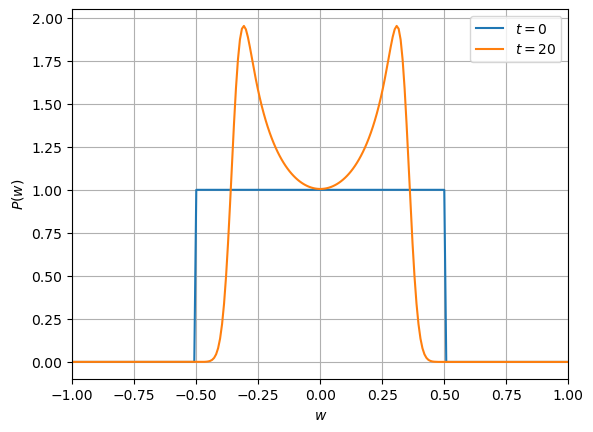

In [7]:
for it in [0, len(P)-1]:
    plt.plot(x-L/2, P[it], label=f'$t={it*dt:g}$')

plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.legend()
plt.xlim(-1,1)
plt.show()

Fixed-time comparisons with different singularity exponents

In [8]:
std_e = 1.
lr = .05
b = 20
time = 30
al = [1,2,3]
L = 4.
w_left, w_right = -.5 + L/2, .5 + L/2
dt = .1
nw = 500

xs, Ps = {}, {}
for a in al:
    q, xs[a], Ps[a] = simulate_sing(std_e, lr, b, dt, time, a, L, nw, w_left, w_right)

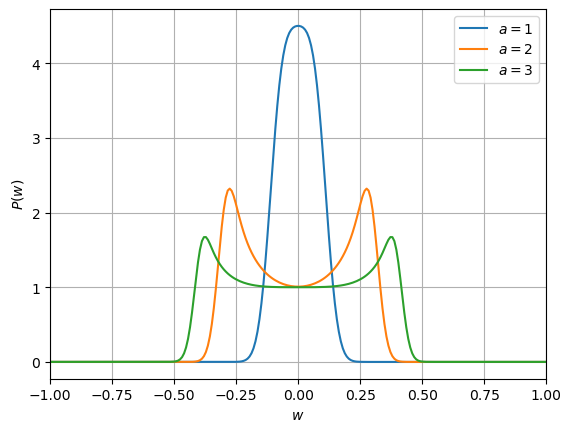

In [9]:
for a in al:
    plt.plot(xs[a]-L/2, Ps[a][-1], label=f'$a={a}$')

plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.legend()
plt.xlim(-1,1)
plt.show()

# Comparison with SGD dynamics

In [113]:
def get_data_sing(q, grad_q, std_e, lr, b, tmax, seed):
    state = np.random.RandomState(seed=seed)
    # initialize randomly in a unit length interval around the critical point
    w_init = state.uniform(-.5,.5)
    S = SGD(std_e, lr, q, grad_q, w_init, b, seed)
    S.evolve(tmax)
    return S.w

## Short-time distribution

In [130]:
# parameters
a = 2. # singularity exponent
tmax = 20
ste_e = 1.
lr = .05
b = 20

# SGD-specific settings
nsamp = 5*10**4

def q(w):
    return w**a
    
def grad_q(w):
    return a*w**(a-1.)

# Fokker-Planck-specific settings
L = 4. # length of the simulation interval
dt = .1 # time step
nw = 400 # spatial discretization
w_left, w_right = -.5 + L/2, .5 + L/2 # initial probability density interval (has to with SGD)

In [131]:
# generate SGD data
sgd_data = np.array([get_data_sing(q, grad_q, std_e, lr, b, tmax, seed) for seed in range(nsamp, 2*nsamp)])

In [132]:
# generate FP data
q, x, P = simulate_sing(std_e, lr, b, dt, tmax, a, L, nw, w_left, w_right)

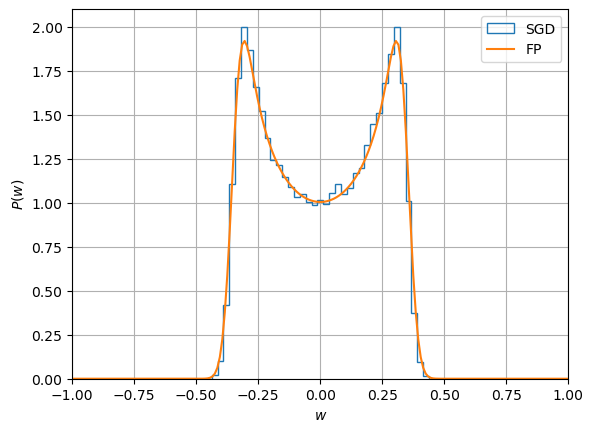

In [133]:
plt.hist(sgd_data.T[-1], histtype='step', density=True, bins='auto', label='SGD')
plt.plot(x-L/2, P[-1], label='FP')
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.legend()
plt.xlim(-1,1)
plt.savefig("distribution_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()

## Convergence to the critical point

In [299]:
# parameters
al = [1,2,3]
tmax = 5000
ste_e = 1.
lr = .01
b = 20

# SGD-specific settings
nsamp = 10**3

# Fokker-Planck-specific settings
L = 1. # length of the simulation interval
dt = .1 # time step
nw = 200 # spatial discretization
w_left, w_right = -.5 + L/2, .5 + L/2 # initial probability density interval (has to with SGD)

In [300]:
# generate SGD data
sgd_data = {}
for a in al:
    def q(w):
        return w**a
    
    def grad_q(w):
        return a*w**(a-1.)

    sgd_data[a] = np.array([get_data_sing(q, grad_q, std_e, lr, b, tmax, seed) for seed in range(nsamp, 2*nsamp)])

In [301]:
# generate FP data
P = {}
for a in al:
    q, x, P[a] = simulate_sing(std_e, lr, b, dt, tmax, a, L, nw, w_left, w_right)

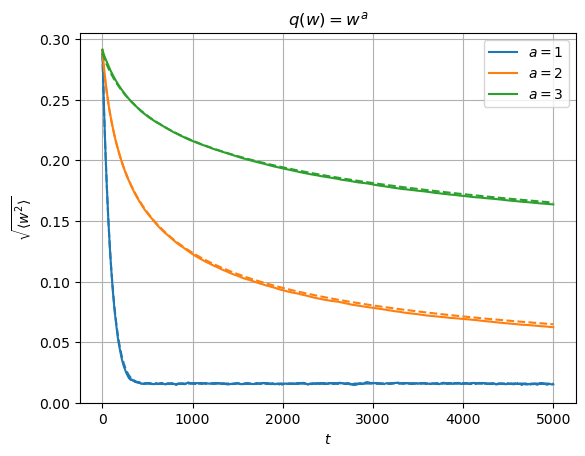

In [302]:
NT = int(tmax/dt) # number of time steps

# distance to critical point
dist = np.abs(np.array(x-L/2))

# default colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, a in enumerate(al):
    # array of distances
    fp_dist = np.sqrt(np.array([np.sum(np.array(pt)/np.sum(np.array(pt)) * dist**2.) for pt in P[a]]))
    
    fp_time = np.linspace(0, tmax, NT+1)
    plt.plot(fp_time, fp_dist, '--', ms=2, color=colors[i])
    
    sgd_dist = np.sqrt(np.mean(np.abs(sgd_data[a])**2., axis=0))
    plt.plot(sgd_dist, color=colors[i], label=f"$a={a}$")

plt.xlabel("$t$")
plt.ylabel(r"$\sqrt{\langle w^2 \rangle}$")
# plt.yscale('log')
# plt.xscale('log')
plt.ylim(ymin=0)
plt.title(r"$q(w) = w^a$")
plt.legend()
plt.grid()
plt.savefig("dynamics_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()